# Deep Neural Network for MNIST Classification

We'll apply all the knowledge from the lectures in this section to write a deep neural network. The problem we've chosen is referred to as the "Hello World" of deep learning because for most students it is the first deep learning algorithm they see.

The dataset is called MNIST and refers to handwritten digit recognition. You can find more about it on Yann LeCun's website (Director of AI Research, Facebook). He is one of the pioneers of what we've been talking about and of more complex approaches that are widely used today, such as covolutional neural networks (CNNs). 

The dataset provides 70,000 images (28x28 pixels) of handwritten digits (1 digit per image). 

The goal is to write an algorithm that detects which digit is written. Since there are only 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), this is a classification problem with 10 classes. 

Our goal would be to build a neural network with 2 hidden layers.

## Import the relevant packages

In [3]:
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

2023-09-03 17:25:37.785900: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-03 17:25:37.823765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 17:25:38.398873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [4]:
# remember the comment from above
# these datasets will be stored in C:\Users\*USERNAME*\tensorflow_datasets\...
# the first time you download a dataset, it is stored in the respective folder 
# every other time, it is automatically loading the copy on your computer 

# tfds.load actually loads a dataset (or downloads and then loads if that's the first time you use it) 
# in our case, we are interesteed in the MNIST; the name of the dataset is the only mandatory argument
# there are other arguments we can specify, which we can find useful
# mnist_dataset = tfds.load(name='mnist', as_supervised=True)
mnist_dataset, mnist_info = tfds.load(name="mnist", with_info=True, as_supervised=True)

# with_info=True will also provide us with a tuple containing information about the version, features, number of samples
# we will use this information a bit below and we will store it in mnist_info

# as_supervised=True will load the dataset in a 2-tuple structure (input, target) 
# alternatively, as_supervised=False, would return a dictionary
# obviously we prefer to have our inputs and targets separated 

# once we have loaded the dataset, we can easily extract the training and testing dataset with the built references
mnist_train, minst_test = mnist_dataset["train"], mnist_dataset["test"]

# by default, TF has training and testing datasets, but no validation sets
# thus we must split it on our own

# we start by defining the number of validation samples as a % of the train samples
# this is also where we make use of mnist_info (we don't have to count the observations)
num_validation_samples = 0.1 * mnist_info.splits["train"].num_examples
# let's cast this number to an integer, as a float may cause an error along the way
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

# let's also store the number of test samples in a dedicated variable (instead of using the mnist_info one)
num_test_samples = mnist_info.splits["test"].num_examples
# once more, we'd prefer an integer (rather than the default float)
num_testsamples = tf.cast(num_test_samples, tf.int64)

# normally, we would like to scale our data in some way to make the result more numerically stable
# in this case we will simply prefer to have inputs between 0 and 1
# let's define a function called: scale, that will take an MNIST image and its label
def scale(image, label):
    # we make surw the value is a float
    image = tf.cast(image, tf.float32)
    # since the possible values for the inputs are 0 to 255 (256 different shades of grey)
    # if we divide each element by 255, we would get the desired result -> all elements will be between 0 and 1 
    image /= 255. # assi and divide

    return image, label

# the method .map() allows us to apply a custom transformation to a given dataset
# we have already decided that we will get the validation data from mnist_train, so 
scaled_train_and_validation_data = mnist_train.map(scale)

# finally, we scale and batch the test data
# we scale it so it has the same magnitude as the train and validation
# there is no need to shuffle it, because we won't be training on the test data
# there would be a single batch, equal to the size of the test data
test_data = minst_test.map(scale)

# let's also shuffle the data

BUFFER_SIZE = 15000
# this BUFFER_SIZE parameter is here for cases when we're dealing with enormous datasets
# then we can't shuffle the whole dataset in one go because we can't fit it all in memory
# so instead TF only stores BUFFER_SIZE samples in memory at a time and shuffles them
# if BUFFER_SIZE=1 => no shuffling will actually happen
# if BUFFER_SIZE >= num samples => shuffling is uniform
# BUFFER_SIZE in between - a computational optimization to approximate uniform shuffling

# luckily for us, there is a shuffle method readily available and we just need to specify the buffer size
shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

# once we have scaled and shuffled the data, we can proceed to actually extracting the train and validation
# our validation data would be equal to 10% of the training set, which we've already calculated
# we use the .take() method to take that many samples
# finally, we create a batch with a batch size equal to the total number of validation samples
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

# similarly, the train_data is everything else, so we skip as many samples as there are in the validation dataset
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

# determize the bath size
BATCH_SIZE = 200

# we can also take advantage of the occasion to batch the train data
# this would be very helpful when we train, as we would be able to iterate over the different batches
train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)

# batch the test data
test_data = test_data.batch(num_test_samples)

# takes next batch (it is the only batch)
# because as_supervized=True, we've got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

2023-09-03 17:25:39.422149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-03 17:25:39.443638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-03 17:25:39.443879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [28]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model

### Outline the model

In [7]:
input_size = 784
output_size = 10
# Use same hidden layer size for both hidden layers. Not a necessity
hidden_layer_size = 500

# define how the model will look like
model = tf.keras.Sequential([

    # the first layer (the input layer)
    # each observation is 28x28x1 pixels, therefore it is a tensor of rank 3
    # since we don't know CNNs yet, we don't know how to feed such input into our net, so we must flatten the images
    # there is a convenient method 'Flatten' that simply takes our 28x28x1 tensor and orders it into a (None,) 
    # or (28x28x1,) = (784,) vector
    # this allows us to actually create a feed forward neural network
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # input layer

    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3rd hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 4th hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 5th hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 6th hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 7th hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 8th hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 9th hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 10th hidden layer

    # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(output_size, activation="softmax") # output layer
])

### Choose the optimizer and the loss function

In [8]:
# we define the optimizer we'd like to use, 
# the loss function, 
# and the metrics we are interested in obtaining at each iteration
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Training

In [9]:
# determine the maximum number of epochs
NUM_EPOCHS = 5

# we fit the model, specifying the
# training data
# the total number of epochs
# and the validation data we just created ourselves in the format: (inputs,targets)
model.fit(train_data, epochs=NUM_EPOCHS, validation_data=(validation_inputs, validation_targets), verbose=2)

Epoch 1/5


2023-09-03 17:25:41.520126: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7df1c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-03 17:25:41.520152: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-09-03 17:25:41.524372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-03 17:25:41.535668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-03 17:25:41.585860: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-03 17:25:41.628876: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


270/270 - 4s - loss: 0.3690 - accuracy: 0.8837 - val_loss: 0.1490 - val_accuracy: 0.9560 - 4s/epoch - 16ms/step
Epoch 2/5
270/270 - 2s - loss: 0.1357 - accuracy: 0.9623 - val_loss: 0.1308 - val_accuracy: 0.9648 - 2s/epoch - 6ms/step
Epoch 3/5
270/270 - 1s - loss: 0.0959 - accuracy: 0.9739 - val_loss: 0.0945 - val_accuracy: 0.9752 - 1s/epoch - 5ms/step
Epoch 4/5
270/270 - 2s - loss: 0.0774 - accuracy: 0.9787 - val_loss: 0.1055 - val_accuracy: 0.9763 - 2s/epoch - 6ms/step
Epoch 5/5
270/270 - 2s - loss: 0.0728 - accuracy: 0.9811 - val_loss: 0.0728 - val_accuracy: 0.9790 - 2s/epoch - 7ms/step


## Test the model

In [10]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 0s 229ms/step - loss: 0.1140 - accuracy: 0.9716


In [11]:
# We can apply some nice formatting if we want to
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.11. Test accuracy: 97.16%


# Check model

In [12]:
import cv2
import matplotlib.pyplot as plt

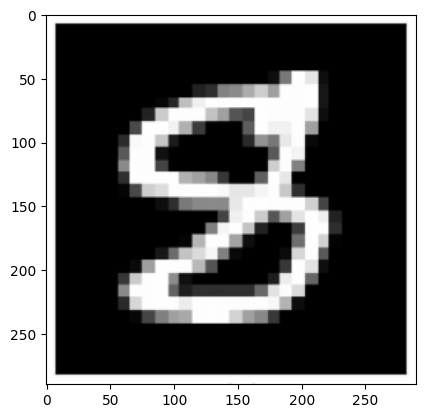

In [13]:
image_input = cv2.imread("6.png")
# scale image input
plt.imshow(image_input)

In [22]:
img = cv2.cvtColor(image_input, cv2.COLOR_BGR2GRAY)
print(img.shape)
img = cv2.resize(img, [28, 28])
img = (255-img) / 255                # normalize as white on black
img = np.expand_dims(img, axis=0) # will move it to (1,28,28)

(290, 290)


In [23]:
img.shape

(1, 28, 28)

In [24]:
input_predction = model.predict(img)
input_pre_label = np.argmax(input_predction) # Returns the indices of the maximum values along an axis.

1/1 [==============================] - 0s 100ms/step


In [25]:
input_predction

array([[5.5895004e-09, 1.4306467e-07, 4.8140305e-06, 9.9981374e-01,
        6.3040184e-11, 1.7857277e-04, 2.3105017e-10, 1.4926282e-07,
        1.8225096e-06, 7.4696413e-07]], dtype=float32)

In [26]:
input_pre_label

3